# Annex 80 Weather Data Task Force Workshop - Day 3

## **Assembling future typical years (EN 15251-4)**

**Release history**

v0 : 2020-09-15

**License**

Licensed by La Rochelle University/LaSIE under a BSD 3 license (https://opensource.org/licenses/BSD-3-Clause).

**To use this code please cite the following publication:**

*Machard, A. , Inard, C., Alessandrini, J.M., Pelé, C., Ribéron, J.
A Methodology for Assembling Future Weather Files Including Heatwaves for Building Thermal Simulations from the European Coordinated Regional Downscaling Experiment (EURO-CORDEX) Climate Data*

https://doi.org/10.3390/en13133424

**Data**

Data for this workshop were downloaded from the CORDEX Platform https://cordex.org/

In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# These should be bias-adjusted data !
# path = r"C:\Users\amachard\Documents\2020-10-23_London_hourly-biasadjusted-weather-data-CORDEX_2050s.csv"
path = r"/Users/xuanluo/Documents/Projects/cordex/future_weather/2020-10-15_WDTF_Los_Angeles_Airport_bias-adjusted-hourly-weather-data-CORDEX_2001-2020-rcp85-new.csv"

df = pd.read_csv(path, index_col='time_lst') ## pd.read_csv(path, index_col=0) depending on the column
df.index = pd.to_datetime(df.index)
#  !!!! Modify here according to years !!!!
# list_of_years = list(range(2041, 2061))
# list_of_years = list(range(2081, 2101))
list_of_years = list(range(2001, 2021))

In [3]:
list_of_years

[2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020]

In [4]:
df_raw = df

In [5]:
df = {}
df['tas'] = []
df['hurs'] = []
df['sfcWind'] = []
df['rsds'] =[]
df['huss'] = []
df['ps'] =[]
for index, row in df_raw.iterrows():
    if not (index.day == 29 and index.month == 2):
        df['tas'].append(row['tas'])
        df['hurs'].append(row['hurs'])
        df['sfcWind'].append(row['sfcWind'])
        df['rsds'].append(row['rsds'])
        df['huss'].append(row['huss'])
        df['ps'].append(row['ps'])

In [6]:
df2 = pd.DataFrame({'tas':df['tas'], 'hurs':df['hurs'], 'rsds':df['rsds'], 
                    'wind':df['sfcWind'], 'huss':df['huss'], 'ps':df['ps']})
idx = pd.date_range(start='2001-01-01 00:00',end='2020-12-31 23:00', freq='1H')
# idx = pd.date_range(start='2041-01-01 00:00',end='2060-12-31 23:00', freq='1H')
# idx = pd.date_range(start='2081-01-01 00:00',end='2100-12-31 23:00', freq='1H')
dates = idx[(idx.day != 29) | (idx.month != 2)] # Remove 29th of February
df2.index = pd.to_datetime(dates)

In [7]:
# Saturated vapor pressure PWS is in hPa
df2.loc[df2.tas < 0, 'PWS'] = 6.105 * np.exp((21.875*df2.tas)/(265.5+df2.tas))
df2.loc[df2.tas > 0, 'PWS'] = 6.105 * np.exp((17.269*df2.tas)/(237.3+df2.tas))

# Vapor pressure PW is in hPa
df2['PW'] = df2['hurs']*df2['PWS']/100 # PV is in hPa

# Water content in kg/kg
df2['W'] = ((df2['PW']*100)/((df2['tas']+273.15)*461.5))*1000

In [8]:
df2.describe()

,tas,hurs,rsds,wind,huss,ps,PWS,PW,W
count,175200.000000,175200.000000,1.752000e+05,175200.000000,175200.000000,175200.000000,175200.000000,175200.000000,175200.000000
mean,16.700037,72.371797,2.150904e+02,1.672269,9.026943,100760.307019,19.659533,13.810210,10.302340
std,4.362935,22.232615,2.959002e+02,0.966320,4.437527,431.263910,5.694173,4.843956,3.541542
min,1.600000,3.000000,3.900000e-07,0.000000,0.347561,97608.075000,6.853537,0.704020,0.528496
25%,13.700000,62.000000,5.948008e-02,0.900000,5.557535,100443.860000,15.668918,10.580121,7.994617
50%,16.600000,79.000000,1.302362e+01,1.400000,8.517907,100729.580000,18.881008,14.284685,10.718979
75%,19.400000,88.000000,4.120000e+02,2.400000,12.143980,101045.951500,22.515543,17.418935,12.957963
max,36.800000,100.000000,1.113000e+03,8.300000,28.408691,102785.980000,62.029004,31.365638,22.628449


In [9]:
df2.to_csv("result_10s.csv")

## **Defining functions to calculate the FS statistic (for each variable and month), and the sum of the ranks**

In [13]:
# We calculate the FS for each variable var (tas, hurs, rsds), for each month m 
# nb is the number of days in the month

def get_FS(var, m, nb):
    
    var_df = pd.DataFrame({'Var':var})
    # Calculating daily averages
    var_df = var_df.resample('24H').mean()
    var_df['month'] = var_df.index.month
    var_df['day'] = var_df.index.day
    var_df['year'] = var_df.index.year
    #print('this is m',m)
#     var_df = var_df[~((var_df['month'] == 2) & (var_df['day'] == 29) & (var_df['year'] == 2084))]
#     var_df = var_df[~((var_df['month'] == 2) & (var_df['day'] == 29) & (var_df['year'] == 2088))]
#     var_df = var_df[~((var_df['month'] == 2) & (var_df['day'] == 29) & (var_df['year'] == 2092))]
#     var_df = var_df[~((var_df['month'] == 2) & (var_df['day'] == 29) & (var_df['year'] == 2096))]
#     var_df = var_df[~((var_df['month'] == 2) & (var_df['day'] == 29) & (var_df['year'] == 2100))]
        
#     var_df = var_df[~((var_df['month'] == 2) & (var_df['day'] == 29) & (var_df['year'] == 2044))]
#     var_df = var_df[~((var_df['month'] == 2) & (var_df['day'] == 29) & (var_df['year'] == 2048))]
#     var_df = var_df[~((var_df['month'] == 2) & (var_df['day'] == 29) & (var_df['year'] == 2052))]
#     var_df = var_df[~((var_df['month'] == 2) & (var_df['day'] == 29) & (var_df['year'] == 2056))]
#     var_df = var_df[~((var_df['month'] == 2) & (var_df['day'] == 29) & (var_df['year'] == 2060))]
        
    var_df = var_df[~((var_df['month'] == 2) & (var_df['day'] == 29) & (var_df['year'] == 2004))]
    var_df = var_df[~((var_df['month'] == 2) & (var_df['day'] == 29) & (var_df['year'] == 2008))]
    var_df = var_df[~((var_df['month'] == 2) & (var_df['day'] == 29) & (var_df['year'] == 2012))]
    var_df = var_df[~((var_df['month'] == 2) & (var_df['day'] == 29) & (var_df['year'] == 2016))]
    var_df = var_df[~((var_df['month'] == 2) & (var_df['day'] == 29) & (var_df['year'] == 2020))]
        
    # Creating a serie of daily variable for that month (m) with data from the all the years (20 in our case)
    var_all_years = var_df.loc[(var_df['month'] == m)]
    print(month+1, ndays[month], len(var_all_years))

    del var_all_years['day']
    del var_all_years['year']
    del var_all_years['month']
    
    # Creating the distribution functions. 
    
    # F is the distribution function for one year (31 in January + 1)
    serie_F = (pd.Series(range(1, (nb+1))))/(nb+1)  ## Equation 2 RANK K(p) DIVIDED BY N+1
    
    # PHI is the distribution function for the 20 years.
    serie_PHI = (pd.Series(range(1, (nb*20+1))))/(nb*20+1) ## Equation 3 RANK J(p) DIVIDED BY n+1

    def get_yearly_sum_FS(var_one_year, var_all_years):
        
        # Sorting the variable by ascending order
        
        var_one_year = var_one_year.sort_values(ascending=True, by=['Var']).squeeze()
#        print(var_one_year.head())
        var_all_years = var_all_years.sort_values(ascending=True, by=['Var']).squeeze()
#         print(m, len(var_all_years), len(serie_PHI))
#        print(var_all_years.tail())

        # Creating a dataframe with the distribution function for 1 year in column F & the temperatures of 1 year in column Variables
        df_one_year = pd.DataFrame({'F': serie_F.values, 'Variables': var_one_year.values, 'Equivalent-PHI': "", 'FS': ""})
#        print(len(serie_PHI),len(var_all_years))

        # Creating a dataframe with the distribution function for 20 years in column PHI & the variables of 20 years in column Variables
        df_all_years = pd.DataFrame({'PHI': serie_PHI.values, 'Variables': var_all_years.values})
        
#        print(var_one_year.head())
        
        # Finding in df_all_years the equivalent var than in df_one_year
        for i in range(len(df_one_year)):
            # Getting the var in df one_year
            var = df_one_year.iloc[i]['Variables']
            # Finding the equivalent var in df all years & storing that row (equivalent temp & Phi of df all years)
            row = df_all_years.loc[df_all_years['Variables'] == var]
            # Getting phi from that row
            phi = row.iloc[0]['PHI']
            # Adding phi to the column 'Equivalent-PHI' in df_one_year
            df_one_year.loc[i, 'Equivalent-PHI'] = phi
            # Calculating FS
            df_one_year.loc[i, 'FS'] = abs(df_one_year.loc[i, 'F']-df_one_year.loc[i, 'Equivalent-PHI'])
            
        # Calculating FS, the sum of the differences (F - PHI) for that month & that year
        sum_FS = df_one_year['FS'].sum()
        
        return sum_FS

    # Creating an empty list in each we will store the FS sums
    list_of_sum_FS = []

    # nb+1 ou nb, ne change rien!!
    for i, g in var_all_years.groupby(np.arange(len(var_all_years)) // nb+1):
    # Getting the sum_FS for each year
        summ_FS = get_yearly_sum_FS(g, var_all_years)
    # Adding the sum_FS to list_of_sum_FS
        list_of_sum_FS.append(summ_FS)

    return list_of_sum_FS

In [14]:
# This function calcules the rank for each variable (tas, hurs, and rsds), and the sum of the ranks of the 3 variables 
# It takes as arguments the FS of each variable
def get_sum(FS_temp, FS_hs, FS_rs):

    def get_rang(FS):
        
        # Creating a dataframe indexed with the years for list_of_sum_FS
        df_fs = pd.DataFrame({'Years': list_of_years, 'FS': FS, 'rang': ""})

        # Sorting the dataframe in ascending order of FSs with the corresponding year
        df_fs = df_fs.sort_values(['FS'], ascending=True)
        
        # Adding the rank column
        df_fs['rang'] = list(range(1, 21)) # nb of years
        # Sorting dataframe per ascending year
        df_fs = df_fs.sort_values(['Years'], ascending=True)
        
        # Returning the rank of each year
        rang = df_fs['rang']
        return rang
    
    # Calling the function and getting the rank
    rang_temp = get_rang(FS_temp)
    rang_hs = get_rang(FS_hs)
    rang_rs = get_rang(FS_rs)

    # Getting the rank of each parameter for each year
    df = pd.DataFrame({'Years': list_of_years, 'Rang-temp': rang_temp, 'Rang-hs': rang_hs, 'Rang-rs': rang_rs})
    
    # Summing the rank for each year
    df['Rang-somme'] = df['Rang-temp'] + df['Rang-hs'] + df['Rang-rs']
    
    # Sorting in order of rank
    df = df.sort_values(['Rang-somme'], ascending=True)
    df = df.reset_index(drop=True)
    
    return df

## **Calling the functions defined above**

In [15]:
# Number of days in the 12 months  
ndays = [31,28,31,30,31,30,31,31,30,31,30,31]

# Creating an empty dictionnary to store the FS for each variable (temp: tas, hs: hurs, rs:rsds)
FS = {'temp':[], 'hs':[], 'rs':[]}

# Creating an empty list to store the ranks of the years for each month
list_dfs_months = []

# For each month and each variable, calling the function get_FS which returns the FS for that variable
# For each month appending to list_dfs_months the ranks (function get_sum)

for month in range(12):
    print(month+1, ndays[month])
    FS['temp'].append(get_FS(df2['tas'],month+1,ndays[month]))
#   For humidity (here hs), it is possible to use relative humidity (hurs) or specific (W) or wapor pressure (PW), here we use PW (as in the Excel)
    FS['hs'].append(get_FS(df2['hurs'],month+1,ndays[month]))
    FS['hs'].append(get_FS(df2['W'],month+1,ndays[month]))
    FS['hs'].append(get_FS(df2['PW'],month+1,ndays[month]))
    FS['rs'].append(get_FS(df2['rsds'],month+1,ndays[month]))
    list_dfs_months.append(get_sum(FS['temp'][month], FS['hs'][month],FS['rs'][month]))

1 31
1 31 620
1 31 620
1 31 620
1 31 620
1 31 620
2 28
2 28 560
2 28 560
2 28 560
2 28 560
2 28 560
3 31
3 31 620
3 31 620
3 31 620
3 31 620
3 31 620
4 30
4 30 600
4 30 600
4 30 600
4 30 600
4 30 600
5 31
5 31 620
5 31 620
5 31 620
5 31 620
5 31 620
6 30
6 30 600
6 30 600
6 30 600
6 30 600
6 30 600
7 31
7 31 620
7 31 620
7 31 620
7 31 620
7 31 620
8 31
8 31 620
8 31 620
8 31 620
8 31 620
8 31 620
9 30
9 30 600
9 30 600
9 30 600
9 30 600
9 30 600
10 31
10 31 620
10 31 620
10 31 620
10 31 620
10 31 620
11 30
11 30 600
11 30 600
11 30 600
11 30 600
11 30 600
12 31
12 31 620
12 31 620
12 31 620
12 31 620
12 31 620


In [16]:
# In list_df_months, for each month, the years are classified by the sum of the ranks
list_dfs_months

[    Years  Rang-temp  Rang-hs  Rang-rs  Rang-somme
 0    2001         11        1        2          14
 1    2019          9        5        5          19
 2    2003          1        3       15          19
 3    2005          8        2       11          21
 4    2010          3        6       12          21
 5    2009          4       13        7          24
 6    2004          7       11        6          24
 7    2020         14        9        1          24
 8    2002         16        7        3          26
 9    2013          6        8       13          27
 10   2006         15        4        9          28
 11   2007          2       14       14          30
 12   2014         19       10        4          33
 13   2016         18       12        8          38
 14   2011         12       17       10          39
 15   2008          5       19       20          44
 16   2015         10       18       18          46
 17   2017         13       20       16          49
 18   2012  

In [17]:
# 2nd order variable Wind
#df_wind = pd.DataFrame({'Wind':df['sfcWind']})
df_wind = pd.DataFrame({'Wind':df2['wind']})

df_wind.index = pd.to_datetime(df_wind.index)

# Calculating the monthly mean of the wind
df_wind = df_wind.resample('1M').mean()
df_wind['month']  = df_wind.index.month
df_wind['year']  = df_wind.index.year

In [18]:
df_wind

,Wind,month,year
2001-01-31,1.972762,1,2001
2001-02-28,1.546604,2,2001
2001-03-31,1.651734,3,2001
2001-04-30,1.871065,4,2001
2001-05-31,1.678986,5,2001
...,...,...,...
2020-08-31,1.800407,8,2020
2020-09-30,1.762565,9,2020
2020-10-31,1.561257,10,2020
2020-11-30,1.334927,11,2020


In [19]:
# Calculating, for each month, the mean wind speed of the 20 years
df_wind_monthly_mean = pd.pivot_table(df_wind, values='Wind',index=["month"], aggfunc='mean')

# Wind mean month by month and year per year
df_wind_sorted_by_month = pd.pivot_table(df_wind, values='Wind',index=['month','year'])

In [20]:
df_wind_monthly_mean

,Wind
month,
1,1.643448
2,1.721466
3,1.743569
4,1.861309
5,1.847053
6,1.739517
7,1.717950
8,1.645212
9,1.571292


In [21]:
df_wind_sorted_by_month

Wind
month year          
1     2001  1.972762
      2002  1.816208
      2003  1.546409
      2004  1.738601
      2005  2.061458
...              ...
12    2016  1.491801
      2017  1.666129
      2018  1.792416
      2019  1.569086
      2020  1.511290

[240 rows x 1 columns]

In [22]:
# This function sorts the wind years by order of least deviation ('Difference') compared to the 20 years monthly mean

def get_df_wind(wind_all_month, wind_month_mean):
    
    # Creating a DataFrame for the wind data of that month
    df_wind_month = pd.DataFrame({'Vitesse': wind_all_month, 'Difference': ""})
    
    # Calculating the difference between the mean of this year & the mean of all years
    df_wind_month['Difference'] = abs(wind_month_mean - df_wind_month['Vitesse'])
    
    # Classifying the wind mean values in ascending order
    df_wind_month = df_wind_month.sort_values(['Difference'], ascending=True)
    
    # Storing the years by order in the 'Years-sorted' column
    df_wind_month['Years-sorted'] = df_wind_month.index.values
    
    # Returning the DataFrame with years sorted in order 
    del df_wind_month['Vitesse']
    df_wind_month = df_wind_month.reset_index(drop=True)
    
    return df_wind_month

In [23]:
# Calling the function, iterating through each month and adding the years sorted by winds to list_dfs_months
liste_years_wind_sorted = []

for month in range(12):
    liste_years_wind_sorted.append(get_df_wind(df_wind_sorted_by_month.Wind[month+1][0:30],df_wind_monthly_mean.Wind[month+1]))
    list_dfs_months[month]['Years-sorted-by-wind'] = liste_years_wind_sorted[month]['Years-sorted']

In [24]:
list_dfs_months

[    Years  Rang-temp  Rang-hs  Rang-rs  Rang-somme  Years-sorted-by-wind
 0    2001         11        1        2          14                  2006
 1    2019          9        5        5          19                  2016
 2    2003          1        3       15          19                  2017
 3    2005          8        2       11          21                  2011
 4    2010          3        6       12          21                  2019
 5    2009          4       13        7          24                  2012
 6    2004          7       11        6          24                  2015
 7    2020         14        9        1          24                  2020
 8    2002         16        7        3          26                  2013
 9    2013          6        8       13          27                  2018
 10   2006         15        4        9          28                  2004
 11   2007          2       14       14          30                  2003
 12   2014         19       10        

In [25]:
# Creating an empty list that will contain the typical years in order per month
list_years=[]

# k is the number of years we consider. If the year classified 3 and 4 have the same rank, we consider both of them.
for month in range(12):
    
    k = 0
    rang,year_min = 3000,0
    
    # Finding out if k = 3 (default), 4 or 5
    if list_dfs_months[month]['Rang-somme'][3] == list_dfs_months[month]['Rang-somme'][2]:
        k = 4
    if list_dfs_months[month]['Rang-somme'][4] == list_dfs_months[month]['Rang-somme'][2]:
        k = 5
    if ((k!=4) and (k!=5)):
        k = 3
    
    # Iterating, for each month, through the k years with the smallest rank 
    for year in list_dfs_months[month][0:k].Years:
        
        # Calculating the rank of that year in the years-sorted-by-wind
        wind_year = list_dfs_months[month]['Years-sorted-by-wind']
        
        # Storing that rank in rg_year
        rg_year=wind_year[wind_year==year].index.values[0]
        print('rang year',rg_year)
        # If the rank of the year is < to rang (initially set as a high number 3000), the minimum year is replaced
        if rg_year < rang:
            year_min = list_dfs_months[month]['Years-sorted-by-wind'][rg_year]
            rang = rg_year
    
    # Adding year_min to list_years
    list_years.append(year_min)
    

print(list_years) 

rang year 17
rang year 4
rang year 11
rang year 7
rang year 18
rang year 17
rang year 1
rang year 0
rang year 4
rang year 13
rang year 19
rang year 16
rang year 2
rang year 18
rang year 7
rang year 15
rang year 8
rang year 19
rang year 1
rang year 9
rang year 0
rang year 16
rang year 2
rang year 7
rang year 0
rang year 4
rang year 10
rang year 14
rang year 13
rang year 11
rang year 14
rang year 9
rang year 2
rang year 1
rang year 15
rang year 3
rang year 10
rang year 7
rang year 14
[2019, 2002, 2002, 2009, 2003, 2019, 2007, 2014, 2009, 2008, 2003, 2004]


In [26]:
list_years

[2019, 2002, 2002, 2009, 2003, 2019, 2007, 2014, 2009, 2008, 2003, 2004]

In [27]:
# Creating the dataframe of the typical year

list_months_str = ['01','02','03','04','05','06','07','08','09','10','11','12']
list_years_str = [str(x) for x in list_years]
dates = [i + '-' + j for i, j in zip(list_years_str, list_months_str)] 

df_type = pd.DataFrame({})
for d in dates:
    print(d)
    df_type = df_type.append(df2[d])

2019-01
2002-02
2002-03
2009-04
2003-05
2019-06
2007-07
2014-08
2009-09
2008-10
2003-11
2004-12


## **Visualizing the typical year**

In [28]:
# 20 years temperature in temp20y

temp20y = pd.DataFrame(df2['tas'])
temp20y.index = pd.to_datetime(temp20y.index)
temp20y['year'] = temp20y.index.year
temp20y['month'] = temp20y.index.month
temp20y['day'] = temp20y.index.day
leap_year = [2004,2008,2012,2016,2020]
# leap_year = [2044,2048,2052,2056,2060]
# leap_year = [2084,2088,2092,2096,2100]

for l in leap_year:
    temp20y = temp20y[~((temp20y['month'] == 2) & (temp20y['day'] == 29) & (temp20y['year'] == l))]

del temp20y['year']
del temp20y['month']
del temp20y['day']
temp20y = temp20y.squeeze()

n = 8760  #chunk row size

# Splitting each year of temperature in list_temp_each_year
list_temp_each_year = [temp20y [i:i+n] for i in range(0,temp20y.shape[0],n)]
list_years_l = [x.to_list() for x in list_temp_each_year]

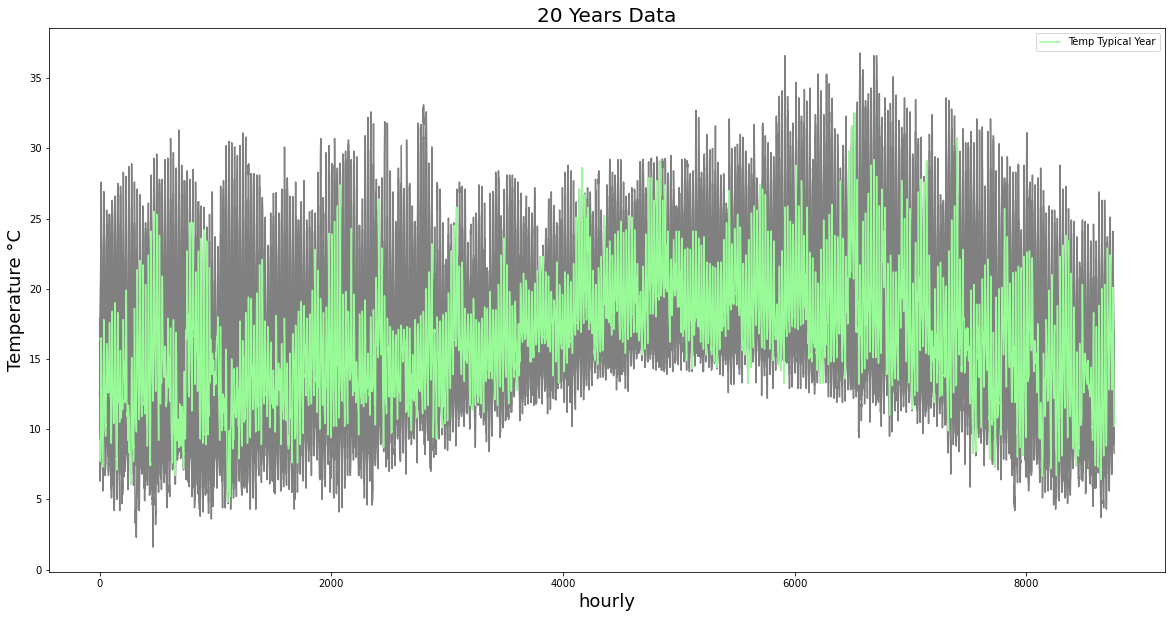

In [29]:
# Plotting the 20 years of temperature and the typical year

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
for i in range(len(list_years_l)):
    ax.plot(list_years_l[i], color='grey')
ax.plot(df_type['tas'].to_list(),color='palegreen',label='Temp Typical Year')
ax.set_xlabel('hourly',fontsize=18)
ax.set_ylabel('Temperature °C',fontsize=18)
ax.set_title('20 Years Data',fontsize=20)
ax.legend()

In [36]:
df_type.head()

,tas,hurs,rsds,wind,huss,ps,PWS,PW,W
2050-01-01 00:00:00,11.856320,88.351246,0.071557,1.531678,9.008084,101155.1489,13.885824,12.268299,9.327347
2050-01-01 01:00:00,12.142304,88.213444,0.010318,1.443563,7.936404,101116.7685,14.150149,12.482334,9.480561
2050-01-01 02:00:00,12.507029,87.428520,0.099184,1.353663,6.864725,101079.7440,14.493656,12.671589,9.612015
2050-01-01 03:00:00,12.997431,85.257592,0.075482,1.443155,6.273670,101113.6333,14.967060,12.760555,9.662912
2050-01-01 04:00:00,13.197765,83.623183,0.045390,1.504488,5.682615,101116.3159,15.164322,12.680888,9.595866


In [ ]:
df_type.to_csv('Los_Angeles_Airport_hourly-biasadjusted-weather-data-CORDEX_2001-2020-TMY.csv')

# **Finding Heatwaves**

**This method was created by:**
*Ouzeau, G., Soubeyroux, J-M., Schneider,M., Vautard R., Planton, S.
Heat waves analysis over France in present and future climate: Application of a new method on the EURO-CORDEX ensemble*

https://doi.org/10.1016/j.cliser.2016.09.002

**It was coded and used for building simulations by:**
*Machard, A. , Inard, C., Alessandrini, J.M., Pelé, C., Ribéron, J.
A Methodology for Assembling Future Weather Files Including Heatwaves for Building Thermal Simulations from the European Coordinated Regional Downscaling Experiment (EURO-CORDEX) Climate Data*

https://doi.org/10.3390/en13133424


In [30]:
# !!! These data (path_hist) MUST BE 20 YEARS OF BIAS-ADJUSTED DATA !!!
# path_hist = r"C:\Users\amachard\Documents\SIMULATIONS-CLIMAT\1.FINAL_FILES_OCTOBER_2020\4_BC_Cordex_1HR_Final\Multiyears-BC_Roissy_IPSL-RCA4_2010s.csv"
path_hist = r'/Users/xuanluo/Documents/cordex/future_weather/2020-10-15_WDTF_Los_Angeles_Airport_hourly-biasadjusted-weather-data-CORDEX_2001-2020-temp.csv'
df_hist = pd.read_csv(path_hist, index_col=0,header=0)
df_hist.index = pd.to_datetime(df_hist.index)

In [31]:
# df = pd.DataFrame.from_dict(df)

In [32]:
# temp_hist = df_hist['tas'].squeeze().resample('24H').mean() # Keeping only 20 years and calculating daily temperature means
# If data imported are already 20 years, please use this line instead of above line: temp_hist = df_hist.squeeze().resample('24H').mean()
temp_hist = df_hist.squeeze().resample('24H').mean()
temp_future = df_raw['tas'].squeeze().resample('24H').mean()

In [33]:
# Temperature thresholds to characterize heatwaves
spic = temp_hist.quantile(0.995)
sdeb = temp_hist.quantile(0.975)
sint = temp_hist.quantile(0.95)

In [34]:
# This function detects heatwaves over a 20 years dataset. 
# It returns a list of heatwaves, the heatwaves, a list of their severities a list of their duration, and a list of their Tmax

def get_dict_hws(daily_temp, spic, sdeb, sint):
    
    # Creating result, an empty dataframe with a series of 20 years daily temperatures
    result = pd.DataFrame({'Daily_Temp': daily_temp, 'sup_SPIC':"", '>SDEB':"", 'cons_SDEB':""})
    result['month']=result.index.month
    
    # Analysing only months from June to September included. !!! These must be replaced according to the summer period of the city of interest !!!
    filter_mask = (result['month'] > 5) & (result['month'] < 10)
    df = result[filter_mask]
    df.index = pd.to_datetime(df.index)
    del df['month']
    
    # Finding where the daily temperature exceeds the threshold SPIC
    df['sup_SPIC'] = np.where(df['Daily_Temp']>spic,df['Daily_Temp'],int(0))
    
    # Finding where the daily temperature exceeds the threshold SDEB
    df['>SDEB'] = np.where(df['Daily_Temp']>sdeb,df['Daily_Temp'],int(0))
    
    # Adding all the temperatures above the SDEB threshold to temp_sdeb
    temp_sdeb = df['>SDEB'].tolist()
    
    # Analyzing if temperatures are consecutive with a minimum of 3 days gap. If yes, filling the 'in between' days wit h1
    for i in range(0,len(temp_sdeb)-4):
    
        if ((temp_sdeb[i]!=0) and (temp_sdeb[i+4]!=0)):
            temp_sdeb[i+1]=1
            temp_sdeb[i+2]=1 
            temp_sdeb[i+3]=1
            
        if ((temp_sdeb[i]!=0) and (temp_sdeb[i+3]!=0)):
            temp_sdeb[i+1]=1
            temp_sdeb[i+2]=1 
            
        if ((temp_sdeb[i]!=0) and (temp_sdeb[i+2]!=0)):
            temp_sdeb[i+1]=1
            
    
    # Adding the list temp_sdeb to the dataframe column 'cons_SDEB'
    df['cons_SDEB'] = temp_sdeb
    
    # Replacing the 1 values with the temperature
    df['cons_SDEB'] = np.where(df['cons_SDEB']==1,df['Daily_Temp'],df['cons_SDEB'])
    
    # Filling with 0 if the heatwaves temperatures fall under the SINT threshold
    df['cons_SDEB'] = np.where(df['cons_SDEB']<sint,int(0),df['cons_SDEB'])
    
    # Keeping only the heatwaves temperatures where there is no 0
    df_reduit = df.loc[(df['cons_SDEB']!=0)]
    del df_reduit['Daily_Temp']
    del df_reduit['>SDEB']
    
    # Storing in hws a list of heatwaves (sorting through consecutive days)
    hws_idx = []
            
    for i in range(0, len(df_reduit)):
        if (df_reduit.index.dayofyear[i]-df_reduit.index.dayofyear[i-1])!=1:
            hws_idx.append(int(np.where(df_reduit.index==df_reduit.index[i])[0]))
    
    hws = []
    for i in range(0, len(hws_idx)-1):
        hws.append(df_reduit.iloc[hws_idx[i]:hws_idx[i+1]])
    
    for i in range(len(hws_idx)-1, len(hws_idx)):
        hws.append(df_reduit.iloc[hws_idx[i]:len(df_reduit)])
    
    ## Keeping in hws2 only the hws for which there is a temp > SPIC 
    hws2 = []
    for i in range(0, len(hws)):
        for a in range(0, len(hws[i])):
            if (hws[i]['sup_SPIC'][a]) > 1:
                hws2.append(hws[i])
                break
    
    ## Keeping in hws3 only the hws that are min 5 days long
    hws3 = []
    for i in range(0, len(hws2)):
        if len(hws2[i])>=5:
            hws3.append(hws2[i])
    
    # Calculating for each heatwave the severity and adding it to the list severities
    severities=[]
    for i in range(0, len(hws3)):
        b=0
        for j in range(0, len(hws3[i])):
            if (hws3[i]['cons_SDEB'][j])>sdeb:
                x = (hws3[i]['cons_SDEB'][j])-sdeb
                b=b+x
            
        severity=b/(spic-sdeb)
        severities.append(severity)
    
    # Calculating for each heatwave the length and adding it to the list lenghts
    lenghts=[]
    for i in range(0, len(hws3)):
        lenghts.append(len(hws3[i]))
    
    # Calculating for each heatwave the Tmax and adding it to the list maxs
    maxs=[]
    for i in range(0, len(hws3)):
        maxs.append(hws3[i]['sup_SPIC'].max())
    
    # Creating liste_hws, a list of lists containing all heatwaves characteristics
    liste_hws = [] 
    for (e, f, g, h) in zip(hws3, lenghts, maxs, severities): 
         liste_hws.append([e,f,g,h])

    return liste_hws, hws3, severities, lenghts, maxs

In [35]:
temp_hist

1/1/01 0:00
2001-01-01    17.875362
2001-01-02    18.062714
2001-01-03    15.824359
2001-01-04    16.184135
2001-01-05    16.281303
                ...    
2020-12-27    17.257425
2020-12-28    16.287179
2020-12-29    16.219231
2020-12-30    16.515224
2020-12-31    20.940732
Freq: 24H, Name: 12.98461538, Length: 7305, dtype: float64

In [36]:
# Calling the function

list_hws_hist = get_dict_hws(temp_hist,spic,sdeb,sint)
list_hws_future = get_dict_hws(temp_future,spic,sdeb,sint)

<ipython-input-34-7f91fab9c236>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sup_SPIC'] = np.where(df['Daily_Temp']>spic,df['Daily_Temp'],int(0))
<ipython-input-34-7f91fab9c236>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['>SDEB'] = np.where(df['Daily_Temp']>sdeb,df['Daily_Temp'],int(0))
<ipython-input-34-7f91fab9c236>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

In [37]:
list_hws_hist

([[              sup_SPIC  cons_SDEB
   1/1/01 0:00                      
   2006-08-20    0.000000  23.528526
   2006-08-21   24.248077  24.248077
   2006-08-22    0.000000  23.932366
   2006-08-23    0.000000  23.632756
   2006-08-24   24.478526  24.478526,
   5,
   24.47852564125,
   4.794126067015175],
  [              sup_SPIC  cons_SDEB
   1/1/01 0:00                      
   2015-09-16    0.000000  23.836699
   2015-09-17    0.000000  23.350710
   2015-09-18    0.000000  22.203663
   2015-09-19   25.341987  25.341987
   2015-09-20    0.000000  23.703365,
   5,
   25.341987179166676,
   4.172158763948458],
  [              sup_SPIC  cons_SDEB
   1/1/01 0:00                      
   2019-08-03   24.426250  24.426250
   2019-08-04   24.583814  24.583814
   2019-08-05    0.000000  23.763671
   2019-08-06   24.333814  24.333814
   2019-08-07   24.096154  24.096154,
   5,
   24.583814102500003,
   6.0317142099903265]],
 [              sup_SPIC  cons_SDEB
  1/1/01 0:00                 

## **Visualizing heatwaves**

In [38]:
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection
#c='wheat'
#ec='chocolate'

c='skyblue'
ec='royalblue'

# Creating patches (circles)
patches = []

# For each heatwave:
# x is the lenght
# y is the tmax
# bubblesize is the severity
    
# Future heatwaves
for i in range(0, len(list_hws_future[2])):
        fig_x_future = list_hws_future[3][i]
        fig_y_future = list_hws_future[4][i]
        fig_bubblesize_future= list_hws_future[2][i]/10
        circle_future = Circle((fig_x_future, fig_y_future), fig_bubblesize_future, color=ec)
        patches.append(circle_future)
        
# Historical heatwaves
for i in range(0, len(list_hws_hist[2])):
        fig_x_hist = list_hws_hist[3][i]
        fig_y_hist = list_hws_hist[4][i]
        fig_bubblesize_hist = list_hws_hist[2][i]/10
        circle_hist = Circle((fig_x_hist, fig_y_hist), fig_bubblesize_hist, color=c)
        patches.append(circle_hist)

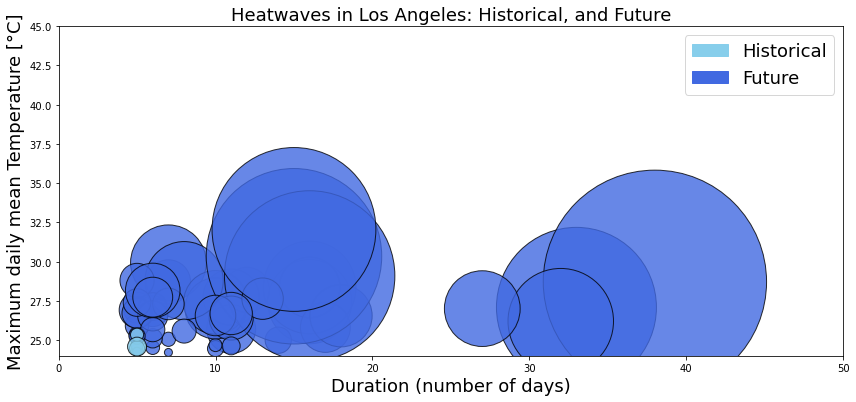

In [39]:
### `PLOT  ####
p = PatchCollection(patches, match_original=True, edgecolor='black') ## this means that the colors given to the patches will be used
p.set_alpha(0.8) ## SET TRANSPARENCY OF BUBBLES
fig, ax = plt.subplots(figsize=(12, 12))
ax.add_collection(p)
ax.set_aspect('equal') ## keep the circles round
plt.legend([circle_hist, circle_future], ['Historical','Future'],fontsize=18)
plt.ylim(top=45,bottom=24)
plt.xlim(right=50, left=0)
plt.xlabel("Duration (number of days)", fontsize=18)
plt.ylabel("Maximum daily mean Temperature [°C]", fontsize=18)
plt.title('Heatwaves in Los Angeles: Historical, and Future', fontsize=18)
plt.tight_layout()
plt.show()